In [192]:
import pandas as pd
import numpy as np
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk
import warnings
from string import digits
from html.parser import HTMLParser
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import (
    wordnet,
    stopwords
)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to C:\Users\Savio
[nltk_data]     Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Savio
[nltk_data]     Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Savio
[nltk_data]     Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Savio Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Savio
[nltk_data]     Coelho\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [193]:
train = pd.read_csv('./data/train.csv', index_col ="tweet_id")

In [194]:
train.head(5)

tweet  sentiment
tweet_id                                                              
1701      #sxswnui #sxsw #apple defining language of tou...          1
1851      Learning ab Google doodles! All doodles should...          1
2689      one of the most in-your-face ex. of stealing t...          2
4525      This iPhone #SXSW app would b pretty awesome i...          0
3604      Line outside the Apple store in Austin waiting...          1

In [207]:
def remove_pattern(input_txt, pattern):
#     print(input_txt)
#     print(pattern)
    r = re.findall(pattern, input_txt)
    for x in r:
        input_txt = re.sub(x, '', input_txt)
    return input_txt

def remove_digits(str_txt):
    remove_digits = str.maketrans('', '', digits)
    str_txt = str_txt.translate(remove_digits)
    return str_txt

# function to remove non-ASCII
def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)
 


def data_cleaning(table):
    #Put everything in lower case
    #table['tweet'] = table['tweet'].str.lower()
    table['tweet'] = table['tweet'].apply(remove_non_ascii)
    #Replace @<some_user>
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "@[\w]*"))
    #replace 'link'
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "link"))
    #replace 'quot'
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "quot"))
    #replace '#'
    #table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "#[\w]*"))
    #Replace RT:rt
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "RT"))
    #Remove URL's
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "r'^https?:\/\/.*[\r\n]*'"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "r'^http?:\/\/.*[\r\n]*'"))
    #Remove Numbers
    table['tweet'] = table['tweet'].apply(lambda row:remove_digits(row))
    #Remove Special Characters & Punctuantions
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "#"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "_"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "&;"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "&gt;"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "&lt;"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, "{}"))
    table['tweet'] = table['tweet'].apply(lambda row:remove_pattern(row, 'r"[^a-zA-Z0-9]"'))
    table['tweet'] = table['tweet'].replace(r'https?://\S+|www\.\S+', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'["$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'#([^\s]+)', r'\1', regex=True)
    return table

In [208]:
#remove Null rows if any
def remove_na(table):
    table = table.dropna()
    return table

In [209]:
from nltk.corpus import stopwords
#Removing Stop Words
def remove_stop_words(table):
    en_stop = set(stopwords.words('english'))
    table['tweet'] = table['tweet'].apply(lambda x:([word for word in x if not word in en_stop]))
    return table

In [210]:
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row

In [211]:
#Removing and replacing contractions eg. wasn't, couldn't, shouldn't....etc
import contractions
def remove_replace_contractions(row):
    str_fixed = contractions.fix(row)
    return str_fixed

In [212]:
train = remove_na(train)
train = data_cleaning(train)
train['tweet'] = train['tweet'].apply(lambda x: detect_elongated_words(x))
train['tweet'] = train['tweet'].apply(lambda x: remove_replace_contractions(x))


In [213]:
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title('Tweets\n', fontsize=18, fontweight='bold')
    plt.show()

In [214]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(train.tweet.values))

plot_wordcloud(wordcloud)

In [215]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(train.tweet[train['sentiment'] == 0]))

plot_wordcloud(wordcloud)

In [216]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(train.tweet[train['sentiment'] == 1]))

plot_wordcloud(wordcloud)

In [217]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(train.tweet[train['sentiment'] == 2]))

plot_wordcloud(wordcloud)

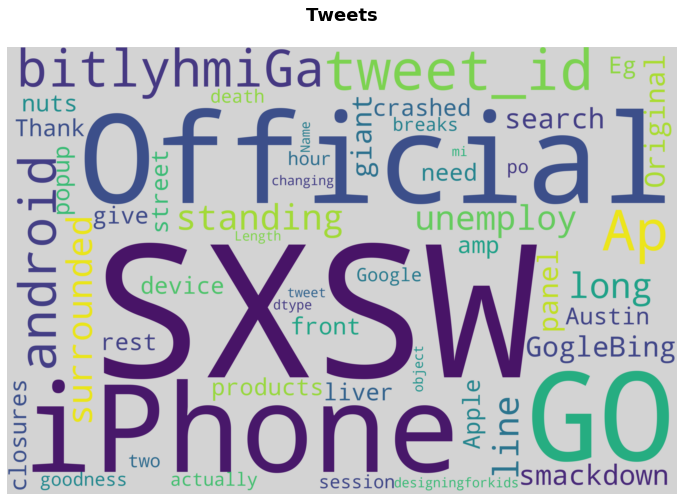

In [218]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(train.tweet[train['sentiment'] == 3]))

plot_wordcloud(wordcloud)